In [1]:
# Import necessary libraries
import re
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load dataset
df = pd.read_csv("premier_league_matches.csv")

print("=" * 60)
print("STEP 1: DATA LOADED")
print("=" * 60)
print(f"Total matches: {len(df)}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
df.head()

STEP 1: DATA LOADED
Total matches: 3372
Columns: 31

First few rows:


,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,SoT,Dist,FK,PK,PKatt,HomeTeam,AwayTeam,Season,Team,MatchID
0,2017-08-12,17:30,Premier League,Matchweek 1,Sat,Away,W,2,0,Brighton and Hove Albion,...,4.0,19.5,2.0,0,0,Brighton and Hove Albion,Manchester City,2017-2018,Manchester City,2017-2018_2017-08-12_Brighton and Hove Albion_...
1,2017-08-21,20:00,Premier League,Matchweek 2,Mon,Home,D,1,1,Everton,...,6.0,20.0,1.0,0,0,Manchester City,Everton,2017-2018,Manchester City,2017-2018_2017-08-21_Manchester City_vs_Everton
2,2017-08-26,12:30,Premier League,Matchweek 3,Sat,Away,W,2,1,Bournemouth,...,8.0,16.2,1.0,0,0,Bournemouth,Manchester City,2017-2018,Manchester City,2017-2018_2017-08-26_Bournemouth_vs_Manchester...
3,2017-09-09,12:30,Premier League,Matchweek 4,Sat,Home,W,5,0,Liverpool,...,10.0,14.0,0.0,0,0,Manchester City,Liverpool,2017-2018,Manchester City,2017-2018_2017-09-09_Manchester City_vs_Liverpool
4,2017-09-16,15:00,Premier League,Matchweek 5,Sat,Away,W,6,0,Watford,...,9.0,17.2,0.0,1,1,Watford,Manchester City,2017-2018,Manchester City,2017-2018_2017-09-16_Watford_vs_Manchester City


In [ ]:
df.info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3372 non-null   object 
 1   Time           3372 non-null   object 
 2   Comp           3372 non-null   object 
 3   Round          3372 non-null   object 
 4   Day            3372 non-null   object 
 5   Venue          3372 non-null   object 
 6   Result         3372 non-null   object 
 7   GF             3372 non-null   int64  
 8   GA             3372 non-null   int64  
 9   Opponent       3372 non-null   object 
 10  xG             3372 non-null   float64
 11  xGA            3372 non-null   float64
 12  Poss           3372 non-null   int64  
 13  Attendance     2851 non-null   float64
 14  Captain        3372 non-null   object 
 15  Formation      3372 non-null   object 
 16  Opp Formation  3372 non-null   object 
 17  Referee        3372 non-null   object 
 18  Match Re

In [6]:
df.isnull().sum()

Date                0
Time                0
Comp                0
Round               0
Day                 0
Venue               0
Result              0
GF                  0
GA                  0
Opponent            0
xG                  0
xGA                 0
Poss                0
Attendance        521
Captain             0
Formation           0
Opp Formation       0
Referee             0
Match Report        0
Notes            3372
Sh                  0
SoT                 0
Dist                2
FK                  0
PK                  0
PKatt               0
HomeTeam            0
AwayTeam            0
Season              0
Team                0
MatchID             0
dtype: int64

In [7]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Attendance     521
Notes         3372
Dist             2
dtype: int64

In [8]:
print("\n" + "=" * 60)
print("STEP 2: CLEANING DATA")
print("=" * 60)

# Drop columns with all nulls
df.drop(columns=["Notes"], inplace=True)

# Fill missing attendance with median per season
df["Attendance"] = df.groupby("Season")["Attendance"].transform(
    lambda x: x.fillna(x.median())
)

# Fill missing distance with overall median
df["Dist"] = df["Dist"].fillna(df["Dist"].median())

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print("✓ Missing values handled")
print(f"  Attendance nulls: {df['Attendance'].isnull().sum()}")
print(f"  Dist nulls: {df['Dist'].isnull().sum()}")
print(f"  Date nulls: {df['Date'].isnull().sum()}")


STEP 2: CLEANING DATA
✓ Missing values handled
  Attendance nulls: 0
  Dist nulls: 0
  Date nulls: 0


In [9]:
print("\n" + "=" * 60)
print("STEP 3: CREATING BASIC FEATURES")
print("=" * 60)

# 1. Home/Away indicator (1 = Home, 0 = Away)
df["is_home"] = (df["Team"] == df["HomeTeam"]).astype(int)

# 2. Extract round number from "Matchweek X"
def extract_round_number(round_str):
    match = re.search(r'\d+', str(round_str))
    return int(match.group()) if match else 0

df['round_num'] = df['Round'].apply(extract_round_number)

print("✓ Basic features created:")
print(f"  - is_home (1=home, 0=away)")
print(f"  - round_num (match week number)")


STEP 3: CREATING BASIC FEATURES
✓ Basic features created:
  - is_home (1=home, 0=away)
  - round_num (match week number)


In [10]:
print("\n" + "=" * 60)
print("STEP 4: SORTING DATA BY TEAM AND DATE")
print("=" * 60)

# Sort by Team and Date (essential for rolling features!)
df = df.sort_values(["Team", "Date"]).reset_index(drop=True)

print("✓ Data sorted chronologically per team")
print("\nSample (first 5 matches for Arsenal):")
print(df[df["Team"] == "Arsenal"][["Team", "Date", "GF", "GA", "Result"]].head())


STEP 4: SORTING DATA BY TEAM AND DATE
✓ Data sorted chronologically per team

Sample (first 5 matches for Arsenal):
      Team       Date  GF  GA Result
0  Arsenal 2017-08-11   4   3      W
1  Arsenal 2017-08-19   0   1      L
2  Arsenal 2017-09-09   3   0      W
3  Arsenal 2017-09-25   2   0      W
4  Arsenal 2017-10-01   2   0      W


In [11]:
print("\n" + "=" * 60)
print("STEP 5: CREATING ROLLING AVERAGES (TEAM FORM)")
print("=" * 60)

# Define which stats to create rolling averages for
rolling_cols = ["GF", "GA", "xG", "xGA", "Poss", "Sh", "SoT"]

# Create rolling averages for last 5 matches
for col in rolling_cols:
    df[f"{col}_roll5"] = df.groupby("Team")[col].transform(
        lambda s: s.shift().rolling(5, min_periods=1).mean()
    )

# Create win rate (last 5 matches)
df["win_flag"] = df["Result"].map({"W": 1, "D": 0.5, "L": 0})
df["win_rate_5"] = df.groupby("Team")["win_flag"].transform(
    lambda s: s.shift().rolling(5, min_periods=1).mean()
)

print("✓ Rolling features created (last 5 matches):")
print(f"  - GF_roll5, GA_roll5, xG_roll5, xGA_roll5")
print(f"  - Poss_roll5, Sh_roll5, SoT_roll5")
print(f"  - win_rate_5 (form indicator)")

print("\nSample rolling features:")
print(df[["Team", "Date", "GF", "GF_roll5", "win_rate_5"]].head(10))


STEP 5: CREATING ROLLING AVERAGES (TEAM FORM)
✓ Rolling features created (last 5 matches):
  - GF_roll5, GA_roll5, xG_roll5, xGA_roll5
  - Poss_roll5, Sh_roll5, SoT_roll5
  - win_rate_5 (form indicator)

Sample rolling features:
      Team       Date  GF  GF_roll5  win_rate_5
0  Arsenal 2017-08-11   4       NaN         NaN
1  Arsenal 2017-08-19   0  4.000000    1.000000
2  Arsenal 2017-09-09   3  2.000000    0.500000
3  Arsenal 2017-09-25   2  2.333333    0.666667
4  Arsenal 2017-10-01   2  2.250000    0.750000
5  Arsenal 2017-10-14   1  2.200000    0.800000
6  Arsenal 2017-10-22   5  1.600000    0.600000
7  Arsenal 2017-10-28   2  2.600000    0.800000
8  Arsenal 2017-11-26   1  2.400000    0.800000
9  Arsenal 2017-11-29   5  2.200000    0.800000


In [12]:
print("\n" + "=" * 60)
print("STEP 6: CREATING OPPONENT FEATURES")
print("=" * 60)

# Columns we want opponent versions of
opp_cols = [f"{c}_roll5" for c in rolling_cols] + ['win_rate_5']

# Initialize opponent columns
for col in opp_cols:
    df[f'opp_{col}'] = np.nan

# Fill opponent features
print("Processing opponent features...")
total_rows = len(df)

for idx in range(total_rows):
    current_row = df.iloc[idx]
    opponent_name = current_row['Opponent']
    match_date = current_row['Date']
    
    # Find opponent's stats before this match
    opponent_history = df[
        (df['Team'] == opponent_name) & 
        (df['Date'] < match_date)
    ]
    
    if len(opponent_history) > 0:
        # Get opponent's latest stats
        latest_opp_stats = opponent_history.iloc[-1]
        for col in opp_cols:
            df.at[idx, f'opp_{col}'] = latest_opp_stats[col]
    
    # Progress update every 500 rows
    if (idx + 1) % 500 == 0:
        print(f"  Processed {idx + 1}/{total_rows} matches...")

print("✓ Opponent features created")

# Check success rate
opp_missing = df['opp_GF_roll5'].isnull().sum()
success_rate = ((len(df) - opp_missing) / len(df)) * 100
print(f"  Available: {len(df) - opp_missing}/{len(df)} ({success_rate:.1f}%)")


STEP 6: CREATING OPPONENT FEATURES
Processing opponent features...
  Processed 500/3372 matches...
  Processed 1000/3372 matches...
  Processed 1500/3372 matches...
  Processed 2000/3372 matches...
  Processed 2500/3372 matches...
  Processed 3000/3372 matches...
✓ Opponent features created
  Available: 2922/3372 (86.7%)


In [13]:
print("\n" + "=" * 60)
print("STEP 7: CREATING SIMPLE DERIVED FEATURES")
print("=" * 60)

# 1. Goal Difference (most important!)
df['GD_roll5'] = df['GF_roll5'] - df['GA_roll5']
df['opp_GD_roll5'] = df['opp_GF_roll5'] - df['opp_GA_roll5']

# 2. Form Difference (are you in better form than opponent?)
df['form_diff'] = df['win_rate_5'] - df['opp_win_rate_5']

# 3. Days since last match
df["days_since"] = df.groupby("Team")["Date"].transform(
    lambda s: s.diff().dt.days.fillna(999)
)

print("✓ Derived features created:")
print("  - GD_roll5 (goal difference - attack vs defense)")
print("  - opp_GD_roll5 (opponent's goal difference)")
print("  - form_diff (your form - opponent's form)")
print("  - days_since (rest days)")


STEP 7: CREATING SIMPLE DERIVED FEATURES
✓ Derived features created:
  - GD_roll5 (goal difference - attack vs defense)
  - opp_GD_roll5 (opponent's goal difference)
  - form_diff (your form - opponent's form)
  - days_since (rest days)


In [14]:
print("\n" + "=" * 60)
print("STEP 7B: CREATING HEAD-TO-HEAD FEATURES")
print("=" * 60)

# For each match, look at last 3 meetings between these teams
def get_h2h_features(df):
    df['h2h_wins'] = 0.0
    df['h2h_goals_for'] = 0.0
    df['h2h_goals_against'] = 0.0
    
    for idx in range(len(df)):
        team = df.iloc[idx]['Team']
        opponent = df.iloc[idx]['Opponent']
        match_date = df.iloc[idx]['Date']
        
        # Find previous meetings
        prev_meetings = df[
            (df['Date'] < match_date) &
            (
                ((df['Team'] == team) & (df['Opponent'] == opponent)) |
                ((df['Team'] == opponent) & (df['Opponent'] == team))
            )
        ].tail(3)  # Last 3 meetings
        
        if len(prev_meetings) > 0:
            # Filter to get only this team's perspective
            team_meetings = prev_meetings[prev_meetings['Team'] == team]
            
            if len(team_meetings) > 0:
                df.at[idx, 'h2h_wins'] = (team_meetings['Result'] == 'W').sum()
                df.at[idx, 'h2h_goals_for'] = team_meetings['GF'].mean()
                df.at[idx, 'h2h_goals_against'] = team_meetings['GA'].mean()
        
        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{len(df)} matches...")
    
    return df

df = get_h2h_features(df)
print("✓ Head-to-head features created")
print(f"  - h2h_wins (wins in last 3 meetings)")
print(f"  - h2h_goals_for (avg goals scored vs this opponent)")
print(f"  - h2h_goals_against (avg goals conceded vs this opponent)")


STEP 7B: CREATING HEAD-TO-HEAD FEATURES
  Processed 500/3372 matches...
  Processed 1000/3372 matches...
  Processed 1500/3372 matches...
  Processed 2000/3372 matches...
  Processed 2500/3372 matches...
  Processed 3000/3372 matches...
✓ Head-to-head features created
  - h2h_wins (wins in last 3 meetings)
  - h2h_goals_for (avg goals scored vs this opponent)
  - h2h_goals_against (avg goals conceded vs this opponent)


In [15]:
print("\n" + "=" * 60)
print("STEP 7C: CREATING STREAK FEATURES")
print("=" * 60)

def calculate_streak(results):
    """Calculate current win/loss streak"""
    if len(results) == 0:
        return 0
    
    # Convert to list for easier iteration
    results_list = results.tolist()
    
    if len(results_list) == 0:
        return 0
    
    last_result = results_list[-1]
    streak = 0
    
    # Count consecutive same results
    for result in reversed(results_list):
        if result == last_result and result in ['W', 'L']:
            streak += 1 if result == 'W' else -1
        else:
            break
    
    return streak

# Calculate streak for each match (FIXED - iterate differently)
df['streak'] = 0.0

for idx in range(len(df)):
    team = df.iloc[idx]['Team']
    match_date = df.iloc[idx]['Date']
    
    # Get previous results for this team
    prev_results = df[
        (df['Team'] == team) & 
        (df['Date'] < match_date)
    ]['Result'].tail(10)  # Last 10 matches
    
    if len(prev_results) > 0:
        df.at[idx, 'streak'] = calculate_streak(prev_results)
    
    if (idx + 1) % 500 == 0:
        print(f"  Processed {idx + 1}/{len(df)} matches...")

# Home/Away specific form
df['home_form'] = 0.4  # Default value
df['away_form'] = 0.4  # Default value

for idx in range(len(df)):
    team = df.iloc[idx]['Team']
    match_date = df.iloc[idx]['Date']
    is_home = df.iloc[idx]['is_home']
    
    # Get previous HOME matches for this team
    prev_home = df[
        (df['Team'] == team) & 
        (df['Date'] < match_date) &
        (df['is_home'] == 1)
    ]['win_flag'].tail(3)
    
    if len(prev_home) > 0:
        df.at[idx, 'home_form'] = prev_home.mean()
    
    # Get previous AWAY matches for this team
    prev_away = df[
        (df['Team'] == team) & 
        (df['Date'] < match_date) &
        (df['is_home'] == 0)
    ]['win_flag'].tail(3)
    
    if len(prev_away) > 0:
        df.at[idx, 'away_form'] = prev_away.mean()
    
    if (idx + 1) % 500 == 0:
        print(f"  Processed {idx + 1}/{len(df)} matches (home/away form)...")

print("✓ Streak features created")
print(f"  - streak (current win/loss streak)")
print(f"  - home_form (form when playing at home)")
print(f"  - away_form (form when playing away)")


STEP 7C: CREATING STREAK FEATURES
  Processed 500/3372 matches...
  Processed 1000/3372 matches...
  Processed 1500/3372 matches...
  Processed 2000/3372 matches...
  Processed 2500/3372 matches...
  Processed 3000/3372 matches...
  Processed 500/3372 matches (home/away form)...
  Processed 1000/3372 matches (home/away form)...
  Processed 1500/3372 matches (home/away form)...
  Processed 2000/3372 matches (home/away form)...
  Processed 2500/3372 matches (home/away form)...
  Processed 3000/3372 matches (home/away form)...
✓ Streak features created
  - streak (current win/loss streak)
  - home_form (form when playing at home)
  - away_form (form when playing away)


In [16]:
print("\n" + "=" * 60)
print("ADDING MORE POWERFUL FEATURES")
print("=" * 60)

# 1. xG difference (quality of chances)
df['xG_diff_roll5'] = df['xG_roll5'] - df['xGA_roll5']
df['opp_xG_diff_roll5'] = df['opp_xG_roll5'] - df['opp_xGA_roll5']

# 2. Shot accuracy
df['shot_accuracy'] = df['SoT_roll5'] / (df['Sh_roll5'] + 1)
df['opp_shot_accuracy'] = df['opp_SoT_roll5'] / (df['opp_Sh_roll5'] + 1)

# 3. Match importance (later in season = more important)
df['season_progress'] = df['round_num'] / 38

print("✓ Additional features added")


ADDING MORE POWERFUL FEATURES
✓ Additional features added


In [17]:
print("\n" + "=" * 60)
print("STEP 8: SPLITTING DATA (TIME-BASED)")
print("=" * 60)

# Get seasons in chronological order
seasons_sorted = sorted(df["Season"].unique())
print(f"All seasons: {seasons_sorted}")

# Define splits
train_seasons = seasons_sorted[:-3]  # All except last 3
val_season = [seasons_sorted[-3]]     # 3rd from last
test_season = [seasons_sorted[-2]]    # 2nd from last

# Create splits
train_df = df[df["Season"].isin(train_seasons)].copy()
val_df = df[df["Season"].isin(val_season)].copy()
test_df = df[df["Season"].isin(test_season)].copy()

print(f"\nTrain seasons: {train_seasons}")
print(f"Validation season: {val_season}")
print(f"Test season: {test_season}")
print(f"\nTrain: {len(train_df)} matches")
print(f"Val: {len(val_df)} matches")
print(f"Test: {len(test_df)} matches")


STEP 8: SPLITTING DATA (TIME-BASED)
All seasons: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025', '2025-2026']

Train seasons: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']
Validation season: ['2023-2024']
Test season: ['2024-2025']

Train: 2504 matches
Val: 418 matches
Test: 380 matches


In [19]:
print("\n" + "=" * 60)
print("STEP 9: PREPARING FEATURES AND TARGETS")
print("=" * 60)

# Define what to EXCLUDE from features
exclude_cols = [
    # Target variables (would cause leakage!)
    "Result", "GF", "GA", "xG", "xGA",
    
    # Identifiers (not predictive)
    "Date", "MatchID", "Team", "Opponent", "HomeTeam", "AwayTeam",
    
    # Not useful as-is
    "Time", "Day", "Comp", "Round", "Season",
    
    # Categorical (we'll handle these later if needed)
    "Captain", "Formation", "Opp Formation", "Referee", "Match Report", "Venue",
    
    # Derived from target
    "win_flag"
]

# Get feature columns (everything NOT in exclude list)
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"✓ Total features: {len(feature_cols)}")
print("\nFeatures being used:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# Create X (features) and y (targets) for each split
# TRAIN
X_train = train_df[feature_cols].copy()
y_train_result = train_df["Result"].copy()
y_train_gf = train_df["GF"].copy()
y_train_ga = train_df["GA"].copy()

# VALIDATION
X_val = val_df[feature_cols].copy()
y_val_result = val_df["Result"].copy()
y_val_gf = val_df["GF"].copy()
y_val_ga = val_df["GA"].copy()

# TEST
X_test = test_df[feature_cols].copy()
y_test_result = test_df["Result"].copy()
y_test_gf = test_df["GF"].copy()
y_test_ga = test_df["GA"].copy()

print(f"\n✓ Data prepared")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  X_test shape: {X_test.shape}")


STEP 9: PREPARING FEATURES AND TARGETS
✓ Total features: 41

Features being used:
  1. Poss
  2. Attendance
  3. Sh
  4. SoT
  5. Dist
  6. FK
  7. PK
  8. PKatt
  9. is_home
  10. round_num
  11. GF_roll5
  12. GA_roll5
  13. xG_roll5
  14. xGA_roll5
  15. Poss_roll5
  16. Sh_roll5
  17. SoT_roll5
  18. win_rate_5
  19. opp_GF_roll5
  20. opp_GA_roll5
  21. opp_xG_roll5
  22. opp_xGA_roll5
  23. opp_Poss_roll5
  24. opp_Sh_roll5
  25. opp_SoT_roll5
  26. opp_win_rate_5
  27. GD_roll5
  28. opp_GD_roll5
  29. form_diff
  30. days_since
  31. h2h_wins
  32. h2h_goals_for
  33. h2h_goals_against
  34. streak
  35. home_form
  36. away_form
  37. xG_diff_roll5
  38. opp_xG_diff_roll5
  39. shot_accuracy
  40. opp_shot_accuracy
  41. season_progress

✓ Data prepared
  X_train shape: (2504, 41)
  X_val shape: (418, 41)
  X_test shape: (380, 41)


In [20]:
print("\n" + "=" * 60)
print("STEP 10: HANDLING MISSING VALUES")
print("=" * 60)

# Check for missing values
missing_train = X_train.isnull().sum()
missing_cols = missing_train[missing_train > 0]

if len(missing_cols) > 0:
    print("Missing values found:")
    print(missing_cols)
else:
    print("No missing values!")

# Fill missing values with median
for col in X_train.columns:
    # Calculate median from training data only
    train_median = X_train[col].median()
    
    # Fill missing in all sets using train median
    X_train[col] = X_train[col].fillna(train_median)
    X_val[col] = X_val[col].fillna(train_median)
    X_test[col] = X_test[col].fillna(train_median)

print("\n✓ Missing values handled")
print(f"  X_train nulls: {X_train.isnull().sum().sum()}")
print(f"  X_val nulls: {X_val.isnull().sum().sum()}")
print(f"  X_test nulls: {X_test.isnull().sum().sum()}")


STEP 10: HANDLING MISSING VALUES
Missing values found:
GF_roll5              29
GA_roll5              29
xG_roll5              29
xGA_roll5             29
Poss_roll5            29
Sh_roll5              29
SoT_roll5             29
win_rate_5            29
opp_GF_roll5         373
opp_GA_roll5         373
opp_xG_roll5         373
opp_xGA_roll5        373
opp_Poss_roll5       373
opp_Sh_roll5         373
opp_SoT_roll5        373
opp_win_rate_5       373
GD_roll5              29
opp_GD_roll5         373
form_diff            379
xG_diff_roll5         29
opp_xG_diff_roll5    373
shot_accuracy         29
opp_shot_accuracy    373
dtype: int64

✓ Missing values handled
  X_train nulls: 0
  X_val nulls: 0
  X_test nulls: 0


In [21]:
# Calculate weights based on goal difference
gf_weights = compute_sample_weight('balanced', y_train_gf.astype(int))
ga_weights = compute_sample_weight('balanced', y_train_ga.astype(int))

print("\n✓ Computed sample weights to handle imbalance")


✓ Computed sample weights to handle imbalance


In [22]:
print("\n" + "=" * 60)
print("STEP 11: TRAINING MODELS")
print("=" * 60)

# Check class distribution
print("Result distribution in training:")
print(y_train_result.value_counts())
print(f"\nPercentages:")
print(y_train_result.value_counts(normalize=True) * 100)

# ========================================
# MODEL 1: Predict Goals For (GF)
# ========================================
print("\n--- Training GF (Goals For) Model ---")

model_gf = RandomForestRegressor(
    n_estimators=300,        # More trees
    max_depth=20,            # Deeper trees
    min_samples_split=5,     # More flexible splitting
    min_samples_leaf=2,      # Smaller leaves
    max_features='sqrt',     # Feature sampling
    random_state=42,
    n_jobs=-1
)

model_gf.fit(X_train, y_train_gf, sample_weight=gf_weights)
print("✓ GF model trained")

# ========================================
# MODEL 2: Predict Goals Against (GA)
# ========================================
print("\n--- Training GA (Goals Against) Model ---")

model_ga = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model_ga.fit(X_train, y_train_ga, sample_weight=ga_weights)
print("✓ GA model trained")


STEP 11: TRAINING MODELS
Result distribution in training:
Result
W    1328
L     601
D     575
Name: count, dtype: int64

Percentages:
Result
W    53.035144
L    24.001597
D    22.963259
Name: proportion, dtype: float64

--- Training GF (Goals For) Model ---
✓ GF model trained

--- Training GA (Goals Against) Model ---
✓ GA model trained


In [23]:
print("\n" + "=" * 60)
print("CREATING TEAM STATISTICS DATABASE")
print("=" * 60)

# Get latest stats for each team (most recent 5 matches average)
team_stats = {}

for team in df['Team'].unique():
    team_data = df[df['Team'] == team].sort_values('Date')
    
    # Get last 5 matches worth of stats
    recent_matches = team_data.tail(10)  # Get last 10 to ensure we have data
    
    if len(recent_matches) > 0:
        latest = recent_matches.iloc[-1]
        
        team_stats[team] = {
            'GF_roll5': latest['GF_roll5'] if pd.notna(latest['GF_roll5']) else 1.5,
            'GA_roll5': latest['GA_roll5'] if pd.notna(latest['GA_roll5']) else 1.0,
            'xG_roll5': latest['xG_roll5'] if pd.notna(latest['xG_roll5']) else 1.4,
            'xGA_roll5': latest['xGA_roll5'] if pd.notna(latest['xGA_roll5']) else 1.0,
            'Poss_roll5': latest['Poss_roll5'] if pd.notna(latest['Poss_roll5']) else 50,
            'Sh_roll5': latest['Sh_roll5'] if pd.notna(latest['Sh_roll5']) else 12,
            'SoT_roll5': latest['SoT_roll5'] if pd.notna(latest['SoT_roll5']) else 4,
            'win_rate_5': latest['win_rate_5'] if pd.notna(latest['win_rate_5']) else 0.4,
            'GD_roll5': latest['GD_roll5'] if pd.notna(latest['GD_roll5']) else 0.5,
            'xG_diff_roll5': latest['xG_diff_roll5'] if pd.notna(latest['xG_diff_roll5']) else 0.4,
            'shot_accuracy': latest['shot_accuracy'] if pd.notna(latest['shot_accuracy']) else 0.33,
        }

# Save team stats
joblib.dump(team_stats, 'team_stats.pkl')
print(f"✓ Team statistics saved for {len(team_stats)} teams")

# Show sample
print("\nSample team stats (Arsenal):")
if 'Arsenal' in team_stats:
    for key, value in team_stats['Arsenal'].items():
        print(f"  {key}: {value:.2f}")


CREATING TEAM STATISTICS DATABASE
✓ Team statistics saved for 32 teams

Sample team stats (Arsenal):
  GF_roll5: 2.20
  GA_roll5: 0.60
  xG_roll5: 1.58
  xGA_roll5: 0.48
  Poss_roll5: 59.40
  Sh_roll5: 15.20
  SoT_roll5: 4.00
  win_rate_5: 0.70
  GD_roll5: 1.60
  xG_diff_roll5: 1.10
  shot_accuracy: 0.25


In [18]:
print("\n" + "=" * 60)
print("STEP 12: VALIDATION SET EVALUATION")
print("=" * 60)

# Predict on validation set
y_val_gf_pred = model_gf.predict(X_val)
y_val_ga_pred = model_ga.predict(X_val)

# Evaluate GF model
mae_gf = mean_absolute_error(y_val_gf, y_val_gf_pred)
rmse_gf = np.sqrt(mean_squared_error(y_val_gf, y_val_gf_pred))
r2_gf = r2_score(y_val_gf, y_val_gf_pred)

print("--- GF Model Performance ---")
print(f"MAE:  {mae_gf:.3f} (on average, off by {mae_gf:.2f} goals)")
print(f"RMSE: {rmse_gf:.3f}")
print(f"R²:   {r2_gf:.3f} (explains {r2_gf*100:.1f}% of variance)")

# Evaluate GA model
mae_ga = mean_absolute_error(y_val_ga, y_val_ga_pred)
rmse_ga = np.sqrt(mean_squared_error(y_val_ga, y_val_ga_pred))
r2_ga = r2_score(y_val_ga, y_val_ga_pred)

print("\n--- GA Model Performance ---")
print(f"MAE:  {mae_ga:.3f} (on average, off by {mae_ga:.2f} goals)")
print(f"RMSE: {rmse_ga:.3f}")
print(f"R²:   {r2_ga:.3f} (explains {r2_ga*100:.1f}% of variance)")


STEP 12: VALIDATION SET EVALUATION
--- GF Model Performance ---
MAE:  0.904 (on average, off by 0.90 goals)
RMSE: 1.135
R²:   0.363 (explains 36.3% of variance)

--- GA Model Performance ---
MAE:  0.926 (on average, off by 0.93 goals)
RMSE: 1.183
R²:   0.078 (explains 7.8% of variance)


In [19]:
print("\n" + "=" * 60)
print("STEP 13: CONVERTING TO MATCH RESULTS")
print("=" * 60)

def predict_match_result(gf_predictions, ga_predictions):
    """
    Smarter conversion with draw threshold
    """
    gf_rounded = np.round(gf_predictions).astype(int)
    ga_rounded = np.round(ga_predictions).astype(int)
    
    results = []
    for gf, ga, gf_raw, ga_raw in zip(gf_rounded, ga_rounded, gf_predictions, ga_predictions):
        goal_diff = gf_raw - ga_raw
        
        # If predicted difference is very small, it's likely a draw
        if abs(goal_diff) < 0.4:  # Threshold for draws
            results.append('D')
        elif gf > ga:
            results.append('W')
        elif gf < ga:
            results.append('L')
        else:
            results.append('D')
    
    return gf_rounded, ga_rounded, np.array(results)

# Get predictions
gf_final, ga_final, result_pred = predict_match_result(y_val_gf_pred, y_val_ga_pred)

# Show examples
print("Sample predictions (with WHOLE numbers!):")
print("\n{:<20} {:<20} {:>12} {:>12} {:>8} {:>8}".format(
    "Team", "Opponent", "Pred Score", "Actual Score", "Pred", "Actual"
))
print("-" * 90)

for i in range(10):
    team = val_df.iloc[i]['Team'][:18]
    opp = val_df.iloc[i]['Opponent'][:18]
    pred_score = f"{gf_final[i]}-{ga_final[i]}"
    actual_score = f"{y_val_gf.iloc[i]}-{y_val_ga.iloc[i]}"
    pred_res = result_pred[i]
    actual_res = y_val_result.iloc[i]
    
    print(f"{team:<20} {opp:<20} {pred_score:>12} {actual_score:>12} {pred_res:>8} {actual_res:>8}")

# Evaluate result accuracy
accuracy = accuracy_score(y_val_result, result_pred)
print(f"\n✓ Result Prediction Accuracy: {accuracy:.1%}")


STEP 13: CONVERTING TO MATCH RESULTS
Sample predictions (with WHOLE numbers!):

Team                 Opponent               Pred Score Actual Score     Pred   Actual
------------------------------------------------------------------------------------------
Arsenal              Nottingham Forest             3-1          2-1        W        W
Arsenal              Crystal Palace                2-2          1-0        D        W
Arsenal              Fulham                        3-1          2-2        W        D
Arsenal              Manchester United             2-1          3-1        W        W
Arsenal              Everton                       2-1          1-0        W        W
Arsenal              Tottenham Hotspur             2-1          2-2        W        D
Arsenal              Bournemouth                   3-1          4-0        W        W
Arsenal              Chelsea                       2-1          2-2        D        D
Arsenal              Sheffield Utd                 2-1

In [20]:
print("\n" + "=" * 60)
print("STEP 14: DETAILED RESULT ANALYSIS")
print("=" * 60)

print("\n--- Classification Report ---")
print(classification_report(y_val_result, result_pred, zero_division=0))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_val_result, result_pred, labels=['W', 'D', 'L'])
print("\n           Predicted")
print("Actual     W    D    L")
print(f"  W     {cm[0][0]:4} {cm[0][1]:4} {cm[0][2]:4}")
print(f"  D     {cm[1][0]:4} {cm[1][1]:4} {cm[1][2]:4}")
print(f"  L     {cm[2][0]:4} {cm[2][1]:4} {cm[2][2]:4}")

# Calculate per-class accuracy
w_correct = cm[0][0] / cm[0].sum() if cm[0].sum() > 0 else 0
d_correct = cm[1][1] / cm[1].sum() if cm[1].sum() > 0 else 0
l_correct = cm[2][2] / cm[2].sum() if cm[2].sum() > 0 else 0

print(f"\nPer-class accuracy:")
print(f"  Wins:  {w_correct:.1%}")
print(f"  Draws: {d_correct:.1%}")
print(f"  Losses: {l_correct:.1%}")


STEP 14: DETAILED RESULT ANALYSIS

--- Classification Report ---
              precision    recall  f1-score   support

           D       0.27      0.49      0.35        89
           L       0.77      0.25      0.38       107
           W       0.72      0.72      0.72       222

    accuracy                           0.55       418
   macro avg       0.59      0.49      0.48       418
weighted avg       0.64      0.55      0.56       418


--- Confusion Matrix ---

           Predicted
Actual     W    D    L
  W      160   61    1
  D       38   44    7
  L       24   56   27

Per-class accuracy:
  Wins:  72.1%
  Draws: 49.4%
  Losses: 25.2%


In [21]:
print("\n" + "=" * 60)
print("STEP 15: FINAL TEST SET EVALUATION")
print("=" * 60)

# Predict on test set
test_gf_pred = model_gf.predict(X_test)
test_ga_pred = model_ga.predict(X_test)

# Convert to whole numbers and results
test_gf_final, test_ga_final, test_result_pred = predict_match_result(
    test_gf_pred, test_ga_pred
)

# Evaluate GF
print("--- GF Predictions ---")
print(f"MAE:  {mean_absolute_error(y_test_gf, test_gf_final):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_gf, test_gf_final)):.3f}")
print(f"R²:   {r2_score(y_test_gf, test_gf_final):.3f}")

# Evaluate GA
print("\n--- GA Predictions ---")
print(f"MAE:  {mean_absolute_error(y_test_ga, test_ga_final):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_ga, test_ga_final)):.3f}")
print(f"R²:   {r2_score(y_test_ga, test_ga_final):.3f}")

# Evaluate Result
test_accuracy = accuracy_score(y_test_result, test_result_pred)
print("\n--- Result Predictions ---")
print(f"Accuracy: {test_accuracy:.1%}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test_result, test_result_pred, zero_division=0))

# Show sample predictions
print("\n--- Sample Test Predictions ---")
test_sample = pd.DataFrame({
    'Team': test_df['Team'].values[:15],
    'Opponent': test_df['Opponent'].values[:15],
    'Pred_Score': [f"{gf}-{ga}" for gf, ga in zip(test_gf_final[:15], test_ga_final[:15])],
    'Actual_Score': [f"{gf}-{ga}" for gf, ga in zip(y_test_gf.values[:15], y_test_ga.values[:15])],
    'Pred_Result': test_result_pred[:15],
    'Actual_Result': y_test_result.values[:15],
    'Correct': ['✓' if p == a else '✗' for p, a in zip(test_result_pred[:15], y_test_result.values[:15])]
})
print(test_sample.to_string(index=False))


STEP 15: FINAL TEST SET EVALUATION
--- GF Predictions ---
MAE:  0.861
RMSE: 1.157
R²:   0.207

--- GA Predictions ---
MAE:  0.839
RMSE: 1.111
R²:   -0.152

--- Result Predictions ---
Accuracy: 48.4%

--- Test Set Classification Report ---
              precision    recall  f1-score   support

           D       0.27      0.49      0.35        93
           L       0.36      0.05      0.09        75
           W       0.68      0.63      0.65       212

    accuracy                           0.48       380
   macro avg       0.44      0.39      0.37       380
weighted avg       0.52      0.48      0.47       380


--- Sample Test Predictions ---
   Team                 Opponent Pred_Score Actual_Score Pred_Result Actual_Result Correct
Arsenal  Wolverhampton Wanderers        2-1          2-0           W             W       ✓
Arsenal              Aston Villa        2-1          2-0           D             W       ✗
Arsenal Brighton and Hove Albion        3-2          1-1           W     


STEP 16: FEATURE IMPORTANCE

--- Top 15 Most Important Features (for GF prediction) ---
       feature  importance
           SoT    0.210771
            Sh    0.097377
          Poss    0.050509
    Poss_roll5    0.043283
      Sh_roll5    0.038874
     SoT_roll5    0.037984
  opp_GD_roll5    0.032448
            PK    0.031239
          Dist    0.031009
  opp_Sh_roll5    0.026887
      GF_roll5    0.026525
      xG_roll5    0.022045
 shot_accuracy    0.021910
 xG_diff_roll5    0.020939
opp_win_rate_5    0.020618


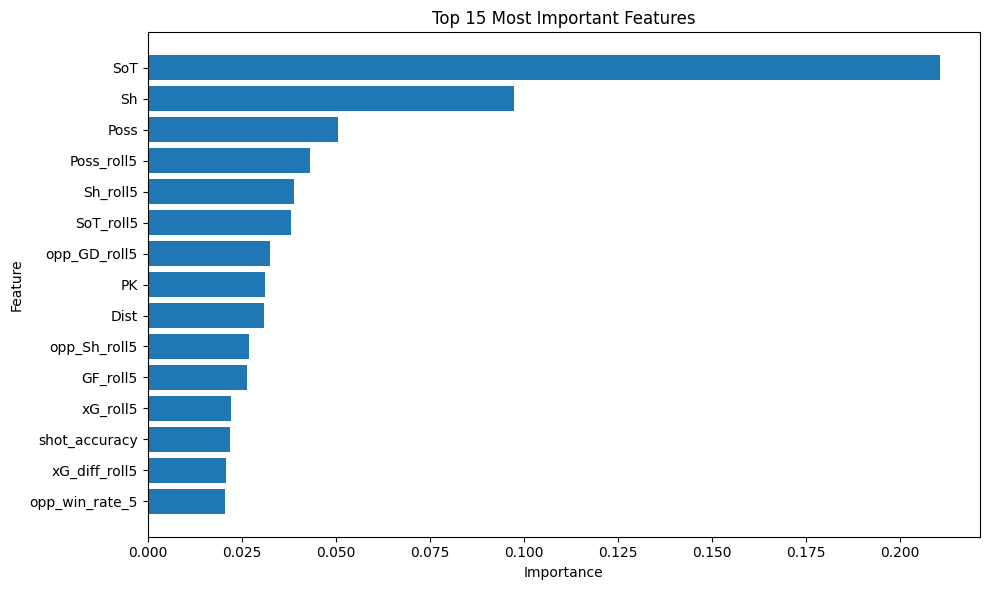


✓ Feature importance chart saved as 'feature_importance.png'


In [22]:
print("\n" + "=" * 60)
print("STEP 16: FEATURE IMPORTANCE")
print("=" * 60)

# Get feature importance from GF model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_gf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 15 Most Important Features (for GF prediction) ---")
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance chart saved as 'feature_importance.png'")

In [23]:
print("\n" + "=" * 60)
print("STEP 17: SAVING MODELS")
print("=" * 60)

# Save models
joblib.dump(model_gf, 'model_gf_simple.pkl')
joblib.dump(model_ga, 'model_ga_simple.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')


STEP 17: SAVING MODELS


['feature_columns.pkl']